# The Speeches in the Parliament of Finland

This project is an exploratory data analysis of a sort about the speeches held in our parliament.

It didn't initially have a elaborate end goal and as of December 2022 the project can't be considered "finished."

It currently covers 
* Comparing the most frequent nouns in the speeches
  * using NLP / lemmatization of Finnish words 
  * analysis uses TF-IDF vectorizer from sk-learn

Other topics of interest which aren't currently covered in greater detail:
* Similarity of the speeches within a party 
  * i.e. were there outliers within the party who talked about very different topics etc.
* Topics revolving around the lengths of speeches
  * Which parties had the longest speeches?
  * How did the frequencies of different parts of speech differ based on different MEPs / parties?
    * i.e. nouns, verbs, adjectives, etc.
  * Anything interesting to be determined based on "intensity of speech"
    * i.e. which MEPs spoke fast (many words per minute)

This analysis doesn't directly imply causations of the impact of people or parties. As a friend of mine mentioned, the speeches held in the committees have also a great impact, and as of now, they are not considered here.

One of the greatest motivations behind this project was to get an *overview* on the topics covered, yet I don't actively follow the politics, and in such a way am less knowledgeable, but also less biased.

The column names haven't been changed from the original Finnish names, and most of the variables are also in Finnish to follow the logic. While the notebook itself is in English, Finnish is needed to understand the insights of the data properly.

### Link to the source data:
DL Link: https://downloads.ctfassets.net/ihup72fnxs9n/6dscMMFAhKQRBx1DuLgSl2/e17c508d9551688c42619263e30a0c98/T__ysistuntojen_puheenvuorot_23082022.xlsx

Initially from here: https://avoindata.eduskunta.fi/#/fi/dataset-search

## Data Cleaning & Exploring columns
### Imports & General glance
Let's first import the required libraries & have a look at the data we'll be working on.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS  # As of DEC 2022, I didn't end up using this library in the latest version yet.
from IPython.core.pylabtools import figsize
figsize(30,10)

#### Metadata (in Finnish) provided by the document

In [2]:
with pd.option_context('display.max_colwidth', 400):
    display(pd.read_excel("./src/T__ysistuntojen_puheenvuorot_23082022.xlsx", sheet_name="Johdanto"))

,Täysistuntojen puheenvuorot 2019–
0,"Tämä koonti sisältää kansanedustajien puheenvuorot täysistunnoissa valtiopäiviltä 2019 alkaen. Puheenvuorot on lajiteltu ajankohdan mukaan vanhimmasta uusimpaan. Tiedot on kerätty eduskunnan avoimen datan rajapinnan kautta, ja taulukon tietosisällöt on kuvattu tarkemmin alempana tällä välilehdellä. Puhemiehen kommenttipuheenvuorot eivät ole mukana."
1,Puheenvuorot-välilehdellä tieto on jaettu seuraaviin sarakkeisiin:
2,"Käsittelyvaihe = Asian, johon puheenvuoro liittyy, käsittelyvaihe."
3,"Vireilletuloasia = Asia, johon puheenvuoro liittyy."
4,Järjestys = Puheenvuoron järjestysnumero kyseisessä asiakohdassa.
5,ID = Puhujan identifioiva ID-tunnus.
6,Asema = Jos puhuja on valtioneuvoston jäsen eli ministeri.
7,"Etunimi, Sukunimi, Eduskuntaryhmä = Puhujan nimi sekä eduskuntaryhmä. Ministereille ei ole merkitty puoluetta."
8,"Puheenvuorotyyppi = Esittelypuheenvuoro, varsinainen puheenvuoro, vastauspuheenvuoro, ryhmäpuheenvuoro tai nopeatahtinen puheenvuoro."
9,Aloitus- ja lopetusajankohta = Puheenvuoron alkamis- ja päättymisajankohta muodossa päivämäärä ja kellonaika.


Some insights from the metadata above:
1. *Speeches may be missing from the table*
2. Last updated on 4 August 2022

Next, let's get the data itself.

#### Import xlsx & info

In [3]:
# puheenvuorot, "speeches"
pvt = pd.read_excel("./src/T__ysistuntojen_puheenvuorot_23082022.xlsx", sheet_name="Puheenvuorot")
pvt.head(3)

,Käsittelyvaihe,Vireilletuloasiakirja,Järjestys,ID,Asema,Etunimi,Sukunimi,Eduskuntaryhmä,Puheenvuorotyyppi,Aloitusajankohta,Lopetusajankohta,Puheenvuoro,Pöytäkirjan verkko-osoite
0,Ainoa käsittely,ETJ 1/2019 vp,1,1092,-,Mika,Niikko,ps,varsinainen puheenvuoro,2019-05-07 14:01:59,2019-05-07 14:06:50,Arvoisa puhemies ja hyvät kollegat! Valtiopäiv...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
1,Ainoa käsittely,ETJ 1/2019 vp,2,1437,-,Juha,Mäenpää,ps,varsinainen puheenvuoro,2019-05-07 14:06:55,2019-05-07 14:14:11,Arvoisa puhemies! Hyvät kollegat! Meiltä kansa...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
2,Ainoa käsittely,ETJ 1/2019 vp,3,1275,-,Mika,Raatikainen,ps,varsinainen puheenvuoro,2019-05-07 14:14:16,2019-05-07 14:14:53,Arvoisa rouva puhemies! Tarkoitus oli puhua pe...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...


In [4]:
pvt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36273 entries, 0 to 36272
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Käsittelyvaihe             36273 non-null  object        
 1   Vireilletuloasiakirja      36273 non-null  object        
 2   Järjestys                  36273 non-null  int64         
 3   ID                         36273 non-null  int64         
 4   Asema                      36273 non-null  object        
 5   Etunimi                    36273 non-null  object        
 6   Sukunimi                   36273 non-null  object        
 7   Eduskuntaryhmä             36273 non-null  object        
 8   Puheenvuorotyyppi          36273 non-null  object        
 9   Aloitusajankohta           36273 non-null  datetime64[ns]
 10  Lopetusajankohta           36273 non-null  object        
 11  Puheenvuoro                36273 non-null  object        
 12  Pöyt

### Confirming contents of columns

While there appear to be **no null** values, let's check applicable columns either way.

The following function is used to get value counts for a column from the pvt dataframe & can be used to get an overview of columns with categories & such (which function as kind of reference data later on)

In [5]:
def plot_column_value_counts_from_pvt(col_name, bar_label_rot_angle=5, omit_rows_with_values=[]):
    
    # These are excluded from print. If omit_rows_with_values is empty, everything gets printed
    plot_mask = pvt[col_name].isin(omit_rows_with_values)
    working_pvt = pvt.drop(pvt.index[plot_mask])
    
    ax = working_pvt[col_name].value_counts().plot.bar(rot=bar_label_rot_angle)  # rotation to prevent texts overlapping

    for i, val in enumerate(working_pvt[col_name].value_counts()):
        ax.text(i, val, str(val), ha="center")

#### Käsittelyvaihe

In [6]:
column_name = "Käsittelyvaihe"

print(pvt[column_name].unique())
print(pvt[column_name].nunique())


['Ainoa käsittely' 'Lähetekeskustelu' 'Ensimmäinen käsittely' 'Keskustelu'
 'Suullinen kyselytunti' 'Toinen käsittely' 'Yksi käsittely'
 'Toinen käsittely, ainoa käsittely'
 'Osittain ainoa, osittain toinen käsittely' 'Mietinnön pöydällepano']
10


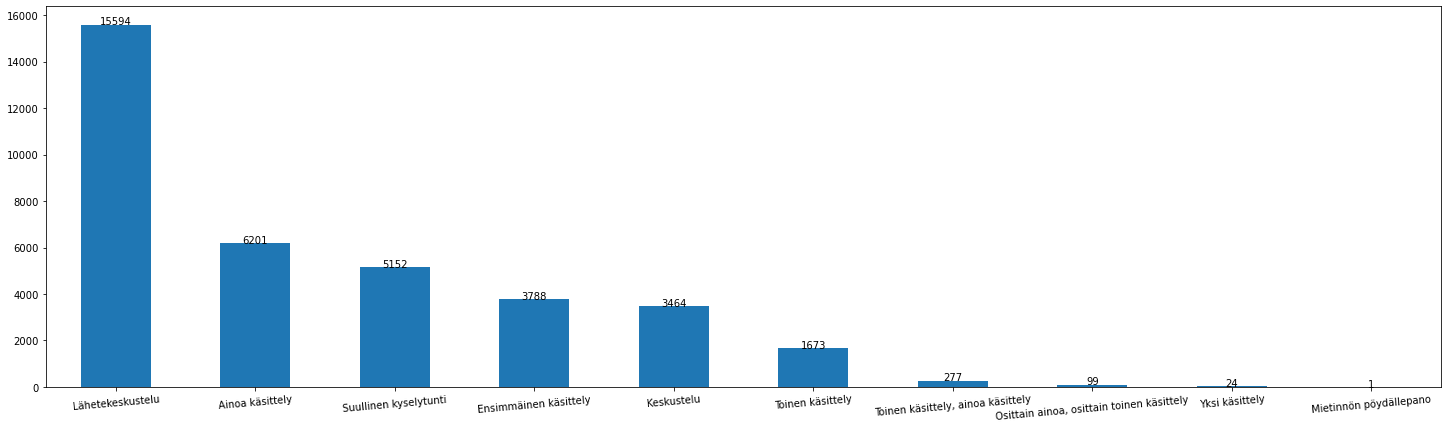

In [7]:
# A wider figsize is useful
figsize(25,7)

plot_column_value_counts_from_pvt(column_name, 5)

This displays each row has a category for Käsittelyvaihe – ~phase of debate. Further descriptions of each could be included here. However, for now, they are omitted.

#### Vireilletuloasiakirja
These all cannot be plotted in a sensible way. This covers the document in which the topic was first brought into the parliament.

In [8]:
column_name = "Vireilletuloasiakirja"
print(pvt[column_name].nunique())

1732


#### Järjestys

Covers the order of a speech per session (i.e. the ordinal number resets when a new session begins). As the column had only integers, it appears there are no problems.

#### ID

The identifier number of a MEP / person presenting. Again, the column consists of `int64` → every row has a value & we are good.

#### Asema
The position of a person giving a speech if they're a minister. 

In [9]:
column_name = "Asema"
print(pvt[column_name].nunique())
pvt[column_name].value_counts()

26


-                                                   31127
Valtiovarainministeri                                 805
Pääministeri                                          684
Perhe- ja peruspalveluministeri                       565
Sisäministeri                                         353
Työministeri                                          305
Elinkeinoministeri                                    304
Oikeusministeri                                       294
Sosiaali- ja terveysministeri                         234
Ulkoministeri                                         229
Opetusministeri                                       226
Liikenne- ja viestintäministeri                       199
Tiede- ja kulttuuriministeri                          176
Maa- ja metsätalousministeri                          135
Eurooppa- ja omistajaohjausministeri                  126
Puolustusministeri                                    124
Ympäristö- ja ilmastoministeri                        111
Kuntaministeri

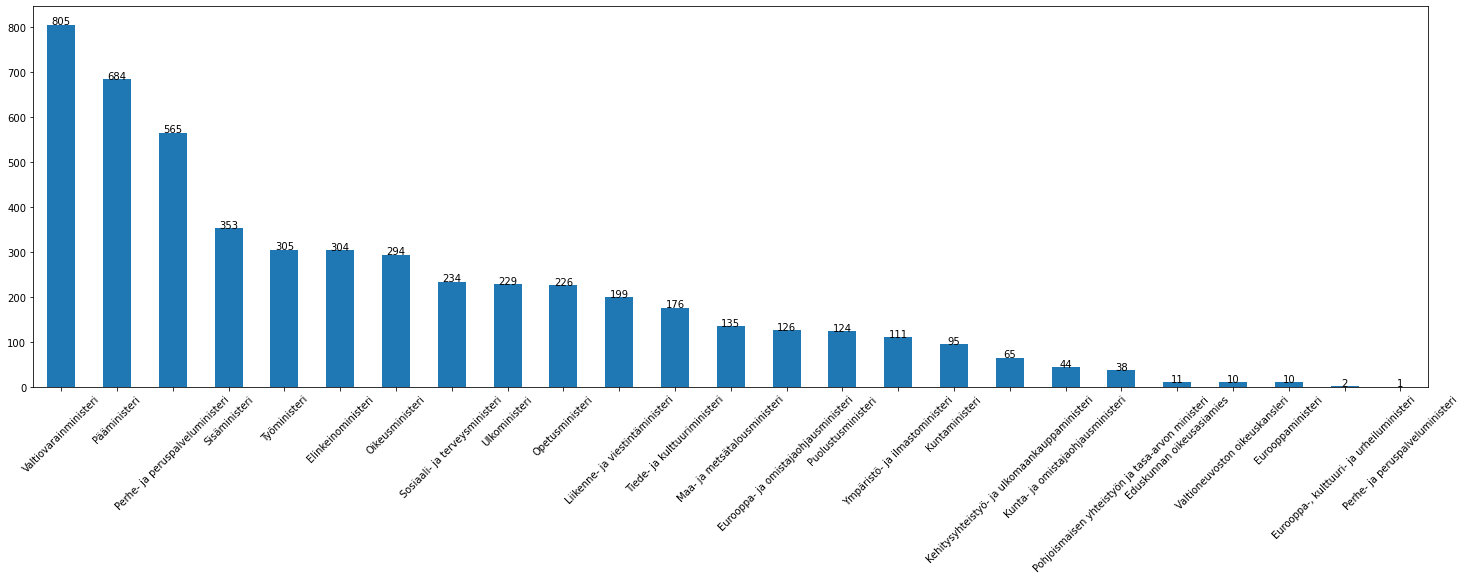

In [10]:
plot_column_value_counts_from_pvt(column_name, 45, ["-"])  # exclude non-ministers

On the topic of data quality, we can notice two things from here
1. There appears to be one case where "Perhe- ja peruspalveluministeri" is written somehow differently. This shall be fixed for our working data, *while one row doesn't have a particularly big impact here*
2. In future use, it should be noted some titles changed over the years & as a follow-up, their speeches can't be tracked as easily.
   * E.g. "Eurooppaministeri", "Eurooppa- ja omistajaohjausministeri", "Eurooppa-, kulttuuri- ja urheiluministeri"
   * They might be different people, too, but the "incomparability between ministers" shall be noted.

Now, let's figure out what's wrong with `Perhe- ja peruspalveluministeri`

In [11]:
pvt[column_name].unique()

array(['-', 'Eurooppa-, kulttuuri- ja urheiluministeri', 'Pääministeri',
       'Valtiovarainministeri', 'Liikenne- ja viestintäministeri',
       'Perhe- ja peruspalveluministeri', 'Opetusministeri',
       'Työministeri', 'Elinkeinoministeri',
       'Sosiaali- ja terveysministeri', 'Sisäministeri',
       'Eurooppaministeri',
       'Kehitysyhteistyö- ja ulkomaankauppaministeri',
       'Kunta- ja omistajaohjausministeri', 'Oikeusministeri',
       'Pohjoismaisen yhteistyön ja tasa-arvon ministeri',
       'Puolustusministeri', 'Ympäristö- ja ilmastoministeri',
       'Tiede- ja kulttuuriministeri', 'Ulkoministeri',
       'Eduskunnan oikeusasiamies', 'Maa- ja metsätalousministeri',
       'Valtioneuvoston oikeuskansleri',
       'Perhe- ja\xa0peruspalveluministeri', 'Kuntaministeri',
       'Eurooppa- ja omistajaohjausministeri'], dtype=object)

Based on the following print, it appears there's a different character as a space in one row which causes an error.

In [12]:
pvt[pvt[column_name] == 'Perhe- ja\xa0peruspalveluministeri']

,Käsittelyvaihe,Vireilletuloasiakirja,Järjestys,ID,Asema,Etunimi,Sukunimi,Eduskuntaryhmä,Puheenvuorotyyppi,Aloitusajankohta,Lopetusajankohta,Puheenvuoro,Pöytäkirjan verkko-osoite
3210,Lähetekeskustelu,HE 22/2019 vp,1,960,Perhe- ja peruspalveluministeri,Krista,Kiuru,-,esittelypuheenvuoro,2019-10-15 14:00:47,2019-10-15 14:06:37,Arvoisa puhemies! Kyseinen hallituksen esitys ...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...


In [13]:
# Let's replace the name with the same one from the data above
pvt[pvt[column_name] == 'Perhe- ja\xa0peruspalveluministeri'][column_name] = "Perhe- ja peruspalveluministeri"

C:\Users\Ari\AppData\Local\Temp\ipykernel_37420\1306601356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pvt[pvt[column_name] == 'Perhe- ja\xa0peruspalveluministeri'][column_name] = "Perhe- ja peruspalveluministeri"


In [14]:
# So apparently I should instead use .loc instead. For that I get the row indexer from above
pvt.loc[3210,"Asema"] = "Perhe- ja peruspalveluministeri"

Well, that little error is fixed now, either way.

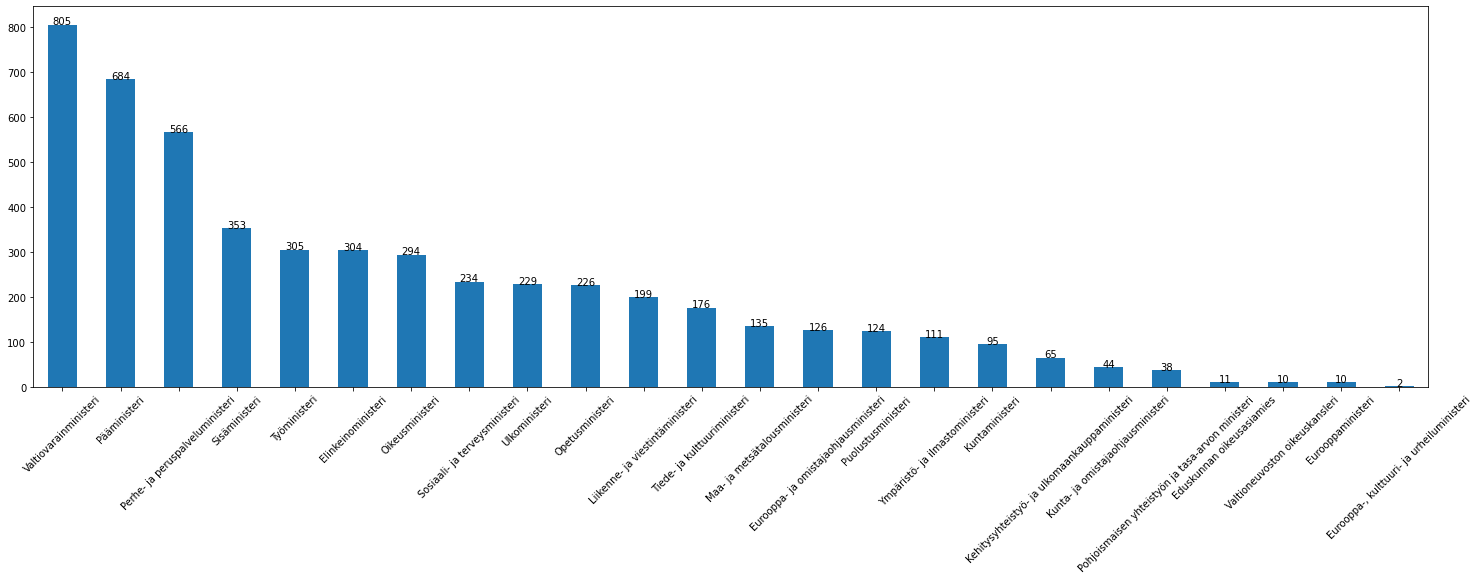

In [15]:
plot_column_value_counts_from_pvt(column_name, 45, ["-"])

#### Eduskuntaryhmä

Similar check can be done for this column. It describes the parliamentary group of a person. They appear to have no issues

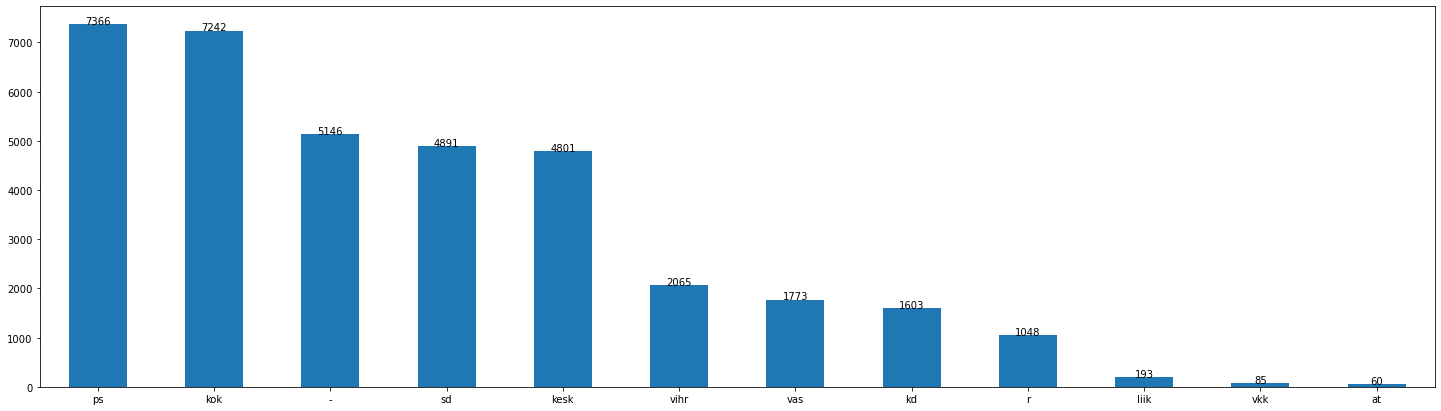

In [16]:
column_name = "Eduskuntaryhmä"
plot_column_value_counts_from_pvt(column_name, 0)

#### Puheenvuorotyyppi

The type of a speech

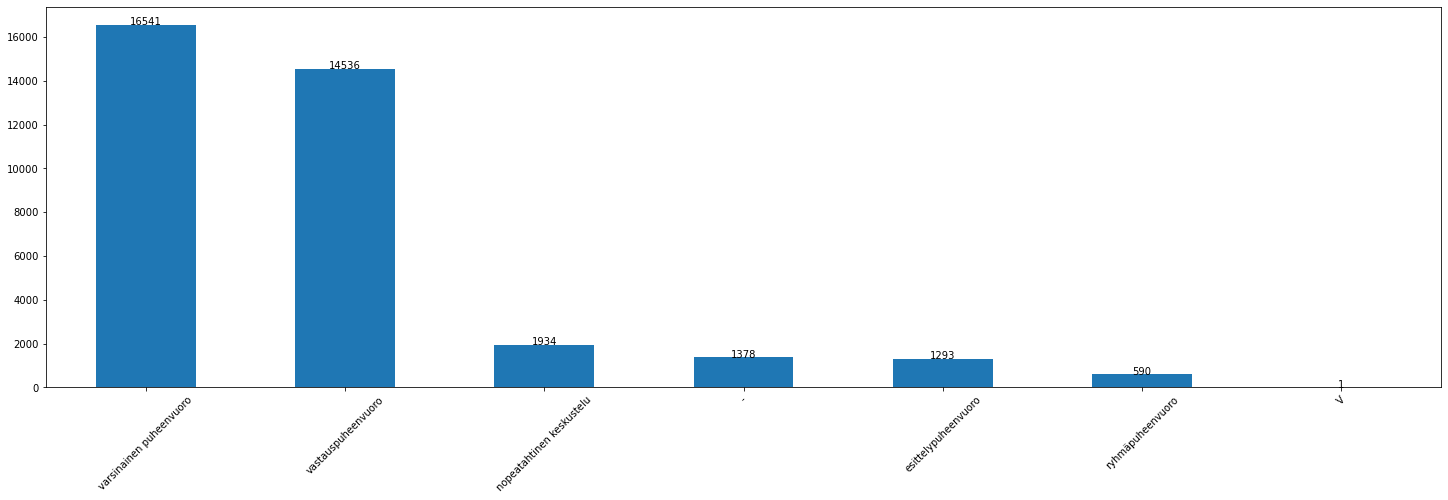

In [17]:
column_name = "Puheenvuorotyyppi"
plot_column_value_counts_from_pvt(column_name, 45)

In [18]:
display(pvt[pvt[column_name] == 'V'])
pvt.loc[31368, "Pöytäkirjan verkko-osoite"]

,Käsittelyvaihe,Vireilletuloasiakirja,Järjestys,ID,Asema,Etunimi,Sukunimi,Eduskuntaryhmä,Puheenvuorotyyppi,Aloitusajankohta,Lopetusajankohta,Puheenvuoro,Pöytäkirjan verkko-osoite
31368,Ensimmäinen käsittely,HE 239/2021 vp,12,1149,-,Markus,Lohi,kesk,V,2022-01-25 14:32:33,2022-01-25 14:33:42,Arvoisa puhemies! Ymmärrän edustaja Kauman toi...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...


'https://www.eduskunta.fi/FI/vaski/PoytakirjaAsiakohta/Sivut/PTK_165+2021+2.aspx'

Based on the minutes, this is a vastauspuheenvuoro (reply/response), let's replace it correctly.

The definition/meaning of blanks (`"-"`) remain a mystery, but there are no other errors in the data.

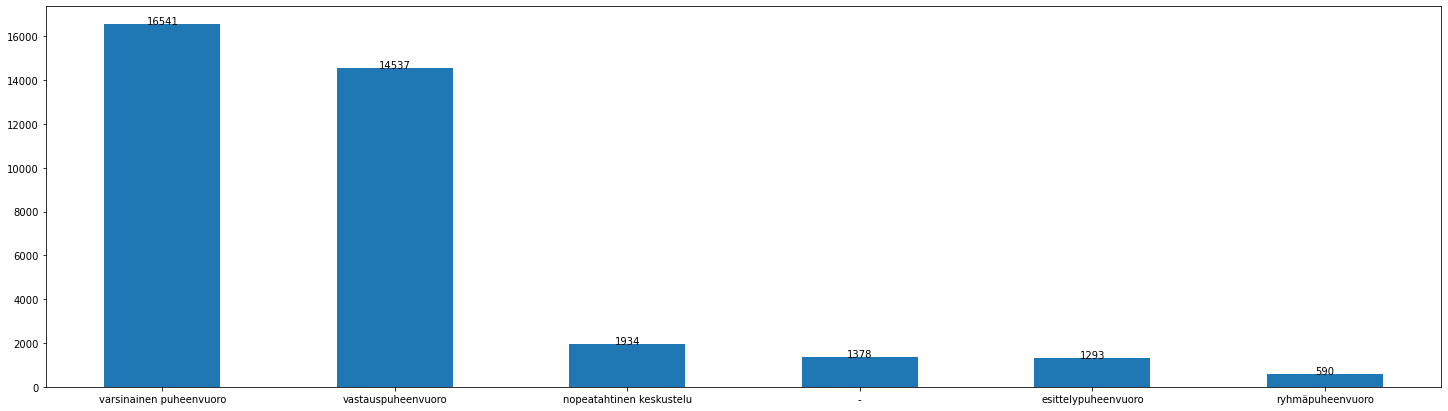

In [19]:
pvt.loc[31368, column_name] = "vastauspuheenvuoro"
plot_column_value_counts_from_pvt(column_name, 0)

#### Aloitusajankohta

The starting time of a speech. According to `pd.info()` the column should be ok.

#### Lopetusajankohta

The ending time of a speech. The fact the datatype of "is `object` (e.g. `string`) instead of `datetime64[ns]` suggests there are some problems. 

In [20]:
column_name = "Lopetusajankohta"
#pvt[column_name].sort_values(axis="index")
# causes Type error
# TypeError: '<' not supported between instances of 'str' and 'datetime.datetime'

So we do have some string values included. At this point exploring with Excel appears to be the practical option which I did, but let's continue it with pandas, too.

In [21]:
# Count types
pvt[column_name].value_counts()

-                      237
2021-05-15 02:31:21     10
2020-04-28 14:38:13      2
2020-04-28 14:40:47      2
2020-04-28 14:47:09      2
                      ... 
2020-06-22 16:07:58      1
2020-06-22 16:05:22      1
2020-06-22 16:03:32      1
2020-06-22 16:00:29      1
2022-07-07 10:54:00      1
Name: Lopetusajankohta, Length: 35997, dtype: int64

Well, 
* apparently 10 speeches were held till 2am in May 2021. Let's have a look
* On April 28, there were some errors give multiple speeches were ended at the same time UNLESS certain types of speeches are logged to transpire during each other. Without knowing the context particularly well, this could be the case for a "nopeatahtinen keskustelu" (fast-tempo discussion)
* ABOVE ALL, some speeches lack the end in the first place!

Let's investigate each of these one by one

In [22]:
# 1. May 15 2021 2am

pvt[pvt[column_name] == pd.to_datetime("2021-05-15 02:31:21")]

,Käsittelyvaihe,Vireilletuloasiakirja,Järjestys,ID,Asema,Etunimi,Sukunimi,Eduskuntaryhmä,Puheenvuorotyyppi,Aloitusajankohta,Lopetusajankohta,Puheenvuoro,Pöytäkirjan verkko-osoite
23279,Ainoa käsittely,HE 260/2020 vp,265,1451,-,Sebastian,Tynkkynen,ps,varsinainen puheenvuoro,2021-05-14 18:05:53,2021-05-15 02:31:21,Arvoisa rouva puhemies! Täällä salissa on vali...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
23280,Ainoa käsittely,HE 260/2020 vp,265,1451,-,Sebastian,Tynkkynen,ps,varsinainen puheenvuoro,2021-05-14 18:05:53,2021-05-15 02:31:21,huomioitaisiin hallituksen toimesta toivotulla...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
23281,Ainoa käsittely,HE 260/2020 vp,265,1451,-,Sebastian,Tynkkynen,ps,varsinainen puheenvuoro,2021-05-14 18:05:53,2021-05-15 02:31:21,"tehdään, että ne toimisivat tukirankana myös v...",https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
23282,Ainoa käsittely,HE 260/2020 vp,265,1451,-,Sebastian,Tynkkynen,ps,varsinainen puheenvuoro,2021-05-14 18:05:53,2021-05-15 02:31:21,"jäsenyydestä, ovat kriisien ja integraatiokehi...",https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
23283,Ainoa käsittely,HE 260/2020 vp,265,1451,-,Sebastian,Tynkkynen,ps,varsinainen puheenvuoro,2021-05-14 18:05:53,2021-05-15 02:31:21,kannustimia julkistalouksiensa tervehdyttämise...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
23284,Ainoa käsittely,HE 260/2020 vp,265,1451,-,Sebastian,Tynkkynen,ps,varsinainen puheenvuoro,2021-05-14 18:05:53,2021-05-15 02:31:21,vaikutukset Suomelle plus- vai miinusmerkkiset...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
23285,Ainoa käsittely,HE 260/2020 vp,265,1451,-,Sebastian,Tynkkynen,ps,varsinainen puheenvuoro,2021-05-14 18:05:53,2021-05-15 02:31:21,muotoiluissaan ja ilmaisuissaan yksiselitteisi...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
23286,Ainoa käsittely,HE 260/2020 vp,265,1451,-,Sebastian,Tynkkynen,ps,varsinainen puheenvuoro,2021-05-14 18:05:53,2021-05-15 02:31:21,"tästä. Toivotaan, että myöskin keskustan kansa...",https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
23287,Ainoa käsittely,HE 260/2020 vp,265,1451,-,Sebastian,Tynkkynen,ps,varsinainen puheenvuoro,2021-05-14 18:05:53,2021-05-15 02:31:21,hirveä määrä. Seuraava viesti: ”Moro! Jos viel...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
23288,Ainoa käsittely,HE 260/2020 vp,265,1451,-,Sebastian,Tynkkynen,ps,varsinainen puheenvuoro,2021-05-14 18:05:53,2021-05-15 02:31:21,On ollut polttava kiire ja välttämätön tarve. ...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...


1. Ah, it's just a casual 8-hour speech, apparently. Come to think about it, I probably heard about this back then.

In [23]:
# 2. April 28, 2020 multiple speeches ending at the same time
pvt[(pvt[column_name] == pd.to_datetime("2020-04-28 14:38:13"))]

,Käsittelyvaihe,Vireilletuloasiakirja,Järjestys,ID,Asema,Etunimi,Sukunimi,Eduskuntaryhmä,Puheenvuorotyyppi,Aloitusajankohta,Lopetusajankohta,Puheenvuoro,Pöytäkirjan verkko-osoite
10127,"Toinen käsittely, ainoa käsittely",HE 44/2020 vp,1,778,-,Sari,Essayah,kd,varsinainen puheenvuoro,2020-04-28 14:35:13,2020-04-28 14:38:13,Arvoisa puhemies! Tämäkin hallituksen esitys l...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
10128,"Toinen käsittely, ainoa käsittely",HE 44/2020 vp,1,778,-,Sari,Essayah,kd,varsinainen puheenvuoro,2020-04-28 14:35:13,2020-04-28 14:38:13,Arvoisa puhemies! Tämäkin hallituksen esitys l...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...


In [24]:
# Appears duplicate, is it?

pvt.loc[10127,:] == pvt.loc[10128,:]

Käsittelyvaihe                True
Vireilletuloasiakirja         True
Järjestys                     True
ID                            True
Asema                         True
Etunimi                       True
Sukunimi                      True
Eduskuntaryhmä                True
Puheenvuorotyyppi             True
Aloitusajankohta              True
Lopetusajankohta              True
Puheenvuoro                   True
Pöytäkirjan verkko-osoite    False
dtype: bool

In [25]:
# How do they differ?

print(pvt.loc[10127,"Pöytäkirjan verkko-osoite"])
print(pvt.loc[10128,"Pöytäkirjan verkko-osoite"])

https://www.eduskunta.fi/FI/vaski/PoytakirjaAsiakohta/Sivut/PTK_63+2020+2.aspx
https://www.eduskunta.fi/FI/vaski/PoytakirjaAsiakohta/Sivut/PTK_63+2020+4.aspx


So the links to minutes change slightly, but the written contents are actually identical. Including duplicate speeches like this will be problematic for the analysis later on!

This The removal of duplicates is considered later. This section is for this column only, including the `'-'`s in Lopetusajankohta.

In [26]:
pvt[pvt[column_name] == "-"]

,Käsittelyvaihe,Vireilletuloasiakirja,Järjestys,ID,Asema,Etunimi,Sukunimi,Eduskuntaryhmä,Puheenvuorotyyppi,Aloitusajankohta,Lopetusajankohta,Puheenvuoro,Pöytäkirjan verkko-osoite
608,Lähetekeskustelu,K 11/2019 vp,12,632,Eduskunnan oikeusasiamies,Petri,Jääskeläinen,-,-,2019-06-13 14:40:34,-,Arvoisa herra puhemies! Olen hyvin ilahtunut s...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
866,Keskustelu,PI 1/2019 vp,82,118,Ulkoministeri,Pekka,Haavisto,-,varsinainen puheenvuoro,2019-06-26 16:03:42,-,Arvoisa puhemies! Omasta puolestani myös kiito...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
867,Keskustelu,PI 1/2019 vp,83,1316,Kehitysyhteistyö- ja ulkomaankauppaministeri,Ville,Skinnari,-,varsinainen puheenvuoro,2019-06-26 16:05:00,-,Arvoisa puhemies! Kiitos myös omasta puolestan...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
1173,Lähetekeskustelu,HE 9/2019 vp,10,1100,-,Sanni,Grahn-Laasonen,kok,-,2019-09-11 14:27:22,-,Arvoisa puhemies! Tästä tietovaranto VARDAstah...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
2192,Lähetekeskustelu,HE 29/2019 vp,3,1301,-,Jani,Mäkelä,ps,ryhmäpuheenvuoro,2019-10-08 12:25:33,-,"Arvoisa puhemies! Hallitus kuvittelee, että Su...",https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32911,Ainoa käsittely,VNS 4/2021 vp,9,499,-,Päivi,Räsänen,kd,ryhmäpuheenvuoro,2022-03-16 14:48:36,-,Arvoisa puhemies! Turvallisuusympäristömme on ...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
33461,Suullinen kyselytunti,SKT 58/2022 vp,4,1298,Sisäministeri,Krista,Mikkonen,-,vastauspuheenvuoro,2022-03-31 16:04:52,-,Arvoisa puhemies! Tällä hetkellä todella tulee...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
34816,Lähetekeskustelu,VNS 3/2022 vp,87,1440,-,Anders,Norrback,r,nopeatahtinen keskustelu,2022-05-16 14:39:26,-,Ärade talman! Diskussionen om Nato har varit a...,https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...
36241,Toinen käsittely,HE 68/2022 vp,3,1439,-,Mauri,Peltokangas,ps,-,2022-07-04 17:48:21,-,"Kiitos, arvoisa puhemies! Kannatan edustaja Pu...",https://www.eduskunta.fi/FI/vaski/PoytakirjaAs...


These are the problematic rows. 

Let's jump back to Excel & check the minutes in greater detail to see if a pattern can be found. I couldn't find one based on the table above.

...

I still couldn't find one from Excel or the minutes, either. There are two *fun* options outside excluding the rows (which would be realistic, as 200 rows out of 30000 isn't that much):

1. Measure the average difference in time between the end of a speech, and the beginning of the next speech
   * Exclude the cases where the next speech is in another session
   * Apply the [beginning of the next speech] - [average time between speeches] as the end speech of the 237 rows above
2. Measure the length of a speech in characters AND in minutes & seconds
   * Based on this, calculate the estimated length of a speech based on the count of characters
     * Could be personalized, too 
       * – as in, the average characters per second could be calculated for every person, and the personal value would be used for every person instead
       * Problematic, as the sample size is smaller (and even then, this doesn't take the state of mind into account)

However, both of these options 
1. Aren't foolproof & their use should be considered either way
2. Aren't related to the content of speeches (in words). I.e., if nothing related to the length of a speech is analyzed, this isn't an issue.

Hence, I'll leave further problem-solving on the specific topic out for now.

**No further edits are to be made on Lopetusajankohta for now!**

### Visual identifiers for groups

Nearly all groups are also parties. Let's use the parties colors' for the gorups to make the plots more informative.

In [27]:
party_codes = list(pvt["Eduskuntaryhmä"].unique())

# vas should be "BF1E24" but it's really close to sd, so change it to a darker #5f0f11
color_codes = ["#FFD500", "#E11931", "#5f0f11", "#006288", "#FFDD93", "#01954B", "#2B67C9", "#CCCCCC", "#61BF1A", "#ae2375", "#444444", "#000000"]
color_dict = dict(zip(party_codes, color_codes))
color_dict

{'ps': '#FFD500',
 'sd': '#E11931',
 'vas': '#5f0f11',
 'kok': '#006288',
 'r': '#FFDD93',
 'kesk': '#01954B',
 'kd': '#2B67C9',
 '-': '#CCCCCC',
 'vihr': '#61BF1A',
 'liik': '#ae2375',
 'at': '#444444',
 'vkk': '#000000'}

In [28]:
pvt["EduskuntaryhmäVäri"] = pvt.apply(lambda row: color_dict[row["Eduskuntaryhmä"]], axis=1)

## Conclusion

Minor edits were done to the files. Due to "Lopetusajankohta" has blanks, the data is not fit for use where the starting or end times, or the length of the speech matters.

However, the current data can be used to analyze the contents in text. The current version with minor edits is now exported to the working database for further use in text analysis.

In [29]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///eduskunta.db', echo=False)

pvt.to_sql("puheenvuorot_bad_times", con=engine, index_label="PvID",
           if_exists="replace")  # NOTE this replaces the existing one every time the file is run!

36273